In [1]:
# Import the necessary modules
from top_n_tool import run_tool

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import langchain
from langchain.cache import SQLiteCache
langchain.llm_cache = SQLiteCache(database_path=".st_langchain.db")

In [3]:
from IPython.display import Markdown, display, HTML

In [4]:
# Define the user query
user_query = """
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.
"""

In [5]:
result_gpt3 = run_tool(user_query, top_n=10, model_name="gpt-3.5-turbo")

100%|██████████| 1/1 [00:00<00:00, 428.95it/s]


In [6]:
Markdown(f"{result_gpt3}")

## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
To address the new query, we can draw comparisons from several past cases:

1. In [[1](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], an individual sought advice on protecting their computer program/app idea when discussing it with potential collaborators. The suggestions included obtaining a patent and entering into non-disclosure agreements (NDAs) with collaborators. These measures can be relevant in the current scenario to protect the video game concept and 3D models.

2. In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], an individual considered working as an independent contractor for a startup. They were concerned about potential issues and sought advice on how to avoid complications. This case can provide insights into potential risks and considerations when hiring independent contractors for the video game project.

3. In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], a content creator wanted to outsource video editing work to a friend in a different country. They sought clarification on whether the friend should be classified as an independent contractor or an employee. This case can provide guidance on the classification of contractors and the legal implications associated with hiring contractors from different countries.

4. In [[8](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)], a startup founder had concerns about paying a contractor who had not completed any projects. They sought clarification on whether they had the right to withhold payment. This case can provide insights into the legal considerations when it comes to paying contractors for their work.

By referencing these past cases, the researcher can gain insights into the potential risks and legal measures to consider when hiring independent contractors for the video game project. They can explore options such as obtaining patents, entering into NDAs, clarifying contractor classifications, and ensuring proper payment terms to protect their intellectual property and ensure fair compensation for the contractors. Additionally, they can seek advice from an intellectual property attorney to navigate the legal complexities involved in protecting their intellectual property across different states and countries.
##### [1] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [8] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906


In [7]:
result_gpt_4 = run_tool(user_query, top_n=10, model_name="gpt-4")

100%|██████████| 1/1 [00:00<00:00, 377.59it/s]


* Cross-encoder rerank

In [8]:
Markdown(f"{result_gpt_4}")

## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
The new query involves a video game designer who is planning to hire independent contractors for programming and 3D modelling tasks. The designer is seeking advice on how to protect their intellectual property and ensure that the contractors are paid for their work. This situation can be compared to several past cases.

In [[1](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], the individual was concerned about protecting their computer program/app idea when discussing it with potential collaborators. The advice given was to consider obtaining a patent and entering into a non-disclosure agreement (NDA) with potential collaborators. This advice could be applicable to the new query as well, as the designer could consider obtaining a patent for their video game and having the contractors sign an NDA to protect the game concept and 3D models.

In [[3](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)], the individual was considering a job offer from a startup that required assistance with software development. The startup wanted the copyright to the individual's code and wanted to ensure that the individual was not liable for any mistakes after the contract ended. This situation is similar to the new query, as the designer could consider including similar terms in the contracts with the contractors to protect their intellectual property and limit their liability.

In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], the individual was a content creator who was seeking assistance in video editing from a friend who resided in a different country. The content creator was unsure whether the friend should be classified as an independent contractor or an employee. This situation could be relevant to the new query, as the designer may need to hire contractors from different states or countries.

In [[7](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/)], the individual and their friends formed an LLC to protect their intellectual property and make their business more official. This could be a potential strategy for the designer to consider, as forming an LLC could provide additional protection for their intellectual property.

In [[8](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)], the founder of a startup was unsure about paying a contractor due to their lack of work. This situation could be relevant to the new query, as the designer may need to consider how to handle payment issues with the contractors.

In [[9](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/)], the founder of a company and a designer reached a verbal agreement regarding the division of equity and revenue share. This could be a potential strategy for the designer to consider, as they could potentially offer equity or revenue share to the contractors as a form of compensation.

In [[10](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/)], a graphic designer was seeking assistance in reviewing and revising their terms and conditions, specifically focusing on the payment schedule section. This could be relevant to the new query, as the designer may need to consider how to structure the payment schedule in the contracts with the contractors.
##### [7] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01, Number: 2499
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [8] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906
##### [3] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [9] ["Structuring a temporary agreement for equity split and revenue share in a startup partnership"](https://www.reddit.com/r/legaladvice/comments/e635kk/how_to_structure_equity_agreement/) - VA, 2019-12-04, Number: 2513
##### [10] ["Clarifying payment schedule in graphic designer's terms and conditions in Texas"](https://www.reddit.com/r/legaladvice/comments/7x69a3/im_writing_my_own_contract_for_freelance_work_and/) - IA, 2018-02-13, Number: 59
##### [1] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253


* Instructor rerank

In [8]:
Markdown(f"{result_gpt_4}")

## New Query:

I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.

## Model Response:
The new query involves a video game designer who is planning to hire independent contractors for programming and 3D modelling tasks. The designer is seeking advice on how to protect their intellectual property and ensure that the contractors are paid for their work. 

This situation shares similarities with several past cases. In [[1](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/)], an 18-year-old college student and their friends formed an LLC to protect their intellectual property while working on a tech-based project. This case could provide insights into the benefits of forming an LLC for the game designer, especially in terms of protecting intellectual property and making the business more official.

The case in [[2](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)] involves an individual considering a job offer from a startup that wants to ensure the individual is not liable for any mistakes after the contract ends. This could be relevant to the game designer's situation, as they might want to include similar clauses in their contracts with the independent contractors.

In [[3](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/)], the individual is seeking advice on how to protect their computer program/app idea when discussing it with potential collaborators. This case could provide useful insights into how the game designer can protect their game concept, such as obtaining a patent or entering into a non-disclosure agreement (NDA) with the contractors.

The situation in [[4](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/)] involves a startup founder unsure about paying a contractor due to their lack of work. This could be relevant to the game designer's situation, as they might face similar issues with their contractors.

In [[6](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/)], a content creator is seeking clarification on whether a friend helping with video editing should be classified as an independent contractor or an employee. This could provide insights into how the game designer should classify their contractors, especially if they are from different states or countries.

Finally, the case in [[7](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/)] involves a graphic artist and game designer considering forming an LLC. This could provide useful information for the game designer, especially in terms of the process and implications of forming an LLC.
##### [1] [Navigating Legal Contracts: Protecting Your Business and Seeking Legal Support](https://www.reddit.com/r/legaladvice/comments/2xliyl/started_a_small_business_about_to_sign_a_large/) - LA, 2015-03-01, Number: 2499
##### [7] ["Forming an LTD for a graphic artist and game designer: business structure, name reservation, and financial implications"](https://www.reddit.com/r/legaladvice/comments/ea7t71/what_are_my_best_steps_to_form_a_business/) - MP, 2019-12-13, Number: 1270
##### [6] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24, Number: 4123
##### [3] ["Protecting your idea while collaborating with strangers in the California Bay Area tech scene"](https://www.reddit.com/r/legaladvice/comments/2xzeee/advice_on_steps_i_can_take_to_protect_my_idea_ie/) - IA, 2015-03-05, Number: 1253
##### [2] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22, Number: 8236
##### [4] ["Legal implications of not paying a contractor during probation period in a startup"](https://www.reddit.com/r/legaladvice/comments/7sbd0a/is_this_legal_to_do_paying_contractors_in_my/) - HI, 2018-01-23, Number: 906


In [10]:
import pandas as pd

In [11]:
import openai
import langchain
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import TextLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS

In [12]:
df = pd.read_parquet("reddit_legal_cluster_test_results.parquet")
df['timestamp'] = pd.to_datetime(df['created_utc'], unit='s')
df['datestamp'] = df['timestamp'].dt.date
print(df.shape)
df.head(1)

(5000, 16)


,index,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title,State,kmeans_label,topic_title,timestamp,datestamp
1078,1078,1575952538,https://www.reddit.com/r/legaladvice/comments/...,e8lsen,I applied for a job and after two interviews I...,"Failed a drug test due to amphetamines, I have...",employment,5,"[9.475638042064453e-05, 0.0005111666301983955,...",493,"""Validity of Schedule II Drug Prescription in ...",PR,8,Employment Legal Concerns and Issues,2019-12-10 04:35:38,2019-12-10


In [ ]:
# Maunually get list of text & embedding pairs, and metadata dicts
metadatas = []
for i, row in df.iterrows():
        metadata={"id_": row["id"],
                  "URL": row['full_link'],
                  "topic_title": row['topic_title'],
                  "case_title": row['llm_title'],
                  "text_label": row['text_label'],
                  "state": row['State'],
                  "date": str(row['datestamp'])}
        metadatas.append(metadata)

embeddings = OpenAIEmbeddings()
text_embeddings = df['embeddings'].tolist()
texts = df['body'].tolist()
ids = df['id'].tolist()
text_embedding_pairs = list(zip(texts, text_embeddings))
id_to_text_map = list(zip(ids, texts))
lc_faiss_index = FAISS.from_embeddings(text_embedding_pairs, embeddings, metadatas=metadatas, ids=ids)

In [ ]:
lc_faiss_index.save_local("lc_faiss_index")

In [13]:
import llama_index

In [14]:
nodes = []
for i, row in df.iterrows():
    node = llama_index.schema.TextNode(
        embedding=row['embeddings'].tolist(),
        id_=row['index'],
        metadata={"URL": row['full_link'],
                    "topic_title": row['topic_title'],
                    "case_title": row['llm_title'],
                    "state": row['State'],
                    "date": str(row['datestamp'])},
        text=row['body'],
        excluded_embed_metadata_keys=['source', 'state', 'date'],
        lookup_index=i,
    )
    nodes.append(node)

In [15]:
from llama_index import VectorStoreIndex, ServiceContext

llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

In [16]:
index = VectorStoreIndex(nodes, service_context=service_context)

In [17]:
response = index.as_retriever().retrieve(user_query)
print(response)

[NodeWithScore(node=TextNode(id_='8627', embedding=[0.010599094232140971, -0.01940659953784975, -0.022989777390714138, -0.03837555943072418, 0.008253617047960292, 0.022292289439365356, -0.0248771006879766, 3.5766602393381734e-05, 0.012951409186528432, -0.03161949228914361, 0.047620705312730834, -0.004328533455289576, -0.004444781602401465, 0.0005312368633700117, 0.006482542829132275, -0.006352618675945547, 0.023837705599837652, 0.005299547116070486, -0.0019471562312935032, 1.260111614495689e-05, -0.029103062467890402, -0.004964479146470936, 0.020733195875834387, -0.01544048699563196, -0.016671349894108883, -0.018873225522044162, 0.017710744982247825, -0.003603692094807284, 0.005873949615761873, -0.02252478480226658, 0.03421797907816841, -0.0024429202990707273, -0.00019285649958059422, -0.020459672029047367, -0.025205330421708087, -0.0012428293455847487, 0.012219730521500638, 0.014442120391378814, 0.02404284801926664, 0.0015283210364634273, 0.019912620610183104, 0.0037814834334091467, -

In [22]:
print(nodes[0].get_metadata_str())

URL: https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/
topic_title: Employment Legal Concerns and Issues
case_title: "Validity of Schedule II Drug Prescription in Texas: When does it expire?"
state: PR
date: 2019-12-10


In [23]:
nodes[0].metadata

{'URL': 'https://www.reddit.com/r/legaladvice/comments/e8lsen/failed_a_drug_test_due_to_amphetamines_i_have_a/',
 'topic_title': 'Employment Legal Concerns and Issues',
 'case_title': '"Validity of Schedule II Drug Prescription in Texas: When does it expire?"',
 'state': 'PR',
 'date': '2019-12-10'}

In [24]:
from llama_index import (
    VectorStoreIndex,
    ServiceContext,
    QueryBundle,
)
from llama_index.indices.postprocessor import LLMRerank
from llama_index.query_engine import CitationQueryEngine

In [25]:
from llama_index.retrievers import VectorIndexRetriever

def get_retrieved_nodes(
    query_str, vector_top_k=10, reranker_top_n=3, with_reranker=False
):
    query_bundle = QueryBundle(query_str)
    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=vector_top_k,
    )
    retrieved_nodes = retriever.retrieve(query_bundle)

    if with_reranker:
        # configure reranker
        reranker = LLMRerank(
            choice_batch_size=5, top_n=reranker_top_n, service_context=service_context
        )
        retrieved_nodes = reranker.postprocess_nodes(retrieved_nodes, query_bundle)

    return retrieved_nodes

In [40]:
new_nodes = get_retrieved_nodes(
    user_query,
    vector_top_k=20,
    reranker_top_n=5,
    with_reranker=True,
)

print(len(new_nodes))

5


In [54]:
new_text_nodes = [node.node for node in new_nodes]

In [63]:
llm = ChatOpenAI(temperature=0.0, model="gpt-3.5-turbo")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=1024)

llm_filtered_index = VectorStoreIndex(new_text_nodes, service_context=service_context)

In [57]:
from llama_index import Prompt

CITATION_TEMPLATE = Prompt(
    "Please provide an answer based solely on the provided sources. "
    "When referencing information from a source, "
    "cite the appropriate source using its corresponding number and URL. "
    "Every answer should include at least one source citation. "
    "Only cite a source when you are explicitly referencing it. "
    "For example:\n"
    "[1]:\n"
    "URL: source_1_address.com\n"
    "Excerpt:\n-----\nThe sky is red in the evening and blue in the morning.\n"
    "[2]:\n"
    "URL: source_2_address.com\n"
    "Excerpt:\n-----\nWater is wet when the sky is red.\n"
    "Query: When is water wet?\n"
    "Answer: Water will be wet when the sky is red [2](source_2_address.com), "
    "which occurs in the evening [1](source_1_address.com).\n"
    "Now it's your turn. Below are several sources of information. ALWAYS cite the information using [[number](URL)] notation:"
    "\n------\n"
    "{context_str}"
    "\n------\n"
    "Query: {query_str}\n"
    "Answer with Citations: "
)

In [64]:
citation_query_engine = CitationQueryEngine.from_args(
    llm_filtered_index,
    citation_qa_template=CITATION_TEMPLATE,
    similarity_top_k=10,
    citation_chunk_size=1024,
)

In [65]:
prompt = f"Using the information, write a detailed comparative analysis for the new query. Using relevant information only, offer insights into how the researcher can reference the past questions to address the new outstanding issue. Do not answer the question or provide opinions, only draw helpful comparisons.\n\nNEW QUERY: {user_query}"
print(prompt)

Using the information, write a detailed comparative analysis for the new query. Using relevant information only, offer insights into how the researcher can reference the past questions to address the new outstanding issue. Do not answer the question or provide opinions, only draw helpful comparisons.

NEW QUERY: 
I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the

In [66]:
response = citation_query_engine.query(prompt)

In [61]:
# Print helper
def print_nodes(response, new_text_nodes):
    k = len(new_text_nodes)
    count = 1
    for i in range(k):
        # add index
        title = response.source_nodes[i].node.metadata['case_title']
        link = f"{response.source_nodes[i].node.metadata['URL']}"
        venue = response.source_nodes[i].node.metadata['state']
        date = response.source_nodes[i].node.metadata['date']
        display(Markdown(f"#### {[count]} [{title}]({link}) - {venue}, {date}"))
        count+=1

* GPT-3.5-turbo

In [67]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{user_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_nodes)

## New Query:


I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.


## Model Output:

Based on the provided sources, there are several insights that can be drawn to address the new query regarding hiring independent contractors for a video game project and ensuring payment and protection of intellectual property.

1. Contracts for Payment and Intellectual Property Protection:
Source 1 provides a similar scenario where an individual is seeking advice on contracts to ensure payment for independent contractors and protection of intellectual property in the video game industry. The individual is designing a video game and wants to hire independent contractors for programming and 3D modeling. They are concerned about contractors taking the game concept and running away with it. While the source does not provide specific contract templates, it highlights the importance of having contracts in place to protect both parties' interests and suggests consulting with an attorney for guidance on drafting such contracts [1].

2. Transferring Copyright and Liability:
Source 2 discusses a situation where an individual is being hired as an independent contractor for a software development startup. The company wants to incorporate in the future and requests the copyright to the contractor's code. This source raises the issue of transferring copyright and advises the individual to be cautious about potential liabilities after the contract ends. It suggests reviewing the agreement carefully and seeking legal advice to avoid any potential legal complications [2].

3. Classification of Independent Contractors:
Source 3 addresses the classification of a video editor as an independent contractor or employee. Although the specific scenario is different, the source provides insights into the factors that determine the classification of a worker. It mentions that the workload being variable and the worker being responsible for their own costs and equipment are factors that lean towards classifying them as an independent contractor. However, the source does not provide a definitive answer and suggests consulting with an attorney or tax professional for a proper classification [3].

4. Contractual Disputes and Representation:
Source 4 discusses a situation where an individual is working as a consultant for a company but is having trouble with the details of the contract and the company's conduct. The individual is unsure about representing the company on their website due to the ongoing issues. While this source does not directly address the issue of hiring independent contractors, it highlights the importance of addressing contractual disputes and ensuring clear communication and expectations between parties involved [4].

By referencing these past questions, the researcher can gain insights into the importance of having contracts in place to ensure payment and protect intellectual property, the potential issues related to transferring copyright and liability, the factors that determine the classification of independent contractors, and the significance of addressing contractual disputes. These insights can guide the researcher in seeking legal advice and drafting appropriate contracts to address their specific concerns and protect their interests when hiring independent contractors for their video game project.

### **Sources:**

#### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12

#### [2] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

#### [3] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24

#### [4] ["Contractual disputes and concerns about representation on company website"](https://www.reddit.com/r/legaladvice/comments/gcgdi7/what_are_the_legal_implications_of_being_listed/) - VT, 2020-05-02

#### [5] ["Legal considerations for setting up a gaming community donations system and hiring developers"](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/) - HI, 2020-05-20

* GPT-4

In [62]:
display(Markdown(f"## New Query:"))
display(Markdown(f"{user_query}"))
display(Markdown(f"## Model Output:"))
display(Markdown(f"{response.response}"))
display(Markdown(f"### **Sources:**"))
print_nodes(response, new_nodes)

## New Query:


I'm currently designing a video game that I know will turn a good profit. The business machinations, marketing, 
and project management are my forte but I lack in the programming and 3D modelling department. So, I'll need to hire 
independent contractors/freelancers to handle those parts to design a "proof of concept" in order to better secure initial 
income via crowdfunding. At this point:  I have virtually no initial startup funds. 
So, I was hoping for advice on what types of contracts I could have them and myself sign to ensure that they get paid 
for their work and how to ensure that my intellectual property is protected. My fears is having a 3D artist or coder 
take the game concept and/or 3D models and running away with it. I'm located in Ohio but will likely need to hire contractors from different states, maybe even different countries.


## Model Output:

The researcher's query shares similarities with the situations described in Source 1 and Source 2. In Source 1, the individual is also designing a video game and is looking to hire independent contractors for programming and 3D modelling, just like the researcher. They are also concerned about protecting their intellectual property and ensuring that the contractors get paid for their work [[1](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/)]. 

Similarly, in Source 2, the individual is being hired as an independent contractor for a software product startup. They are also concerned about the legal implications of transferring copyright to their code to the company [[2](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/)]. 

These two sources could provide the researcher with insights into the types of contracts that could be used to ensure payment and protect intellectual property. They could also provide insights into the potential legal implications of transferring copyright of work produced by independent contractors. 

The researcher's situation also has some parallels with Source 5, where the individual is setting up a gaming community and is considering hiring programmers/developers. They are also concerned about the legal implications of receiving donations and paying the developers from these funds [[5](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/)]. This could provide the researcher with insights into the potential legal considerations of paying contractors from crowdfunding income. 

However, the researcher's situation differs from these sources in that they are located in Ohio and may need to hire contractors from different states or countries. This could introduce additional legal considerations not covered in these sources.

### **Sources:**

#### [1] ["Protecting Intellectual Property and Ensuring Payment: Legal Considerations for Hiring Independent Contractors in the Video Game Industry"](https://www.reddit.com/r/legaladvice/comments/gilww3/oh_advice_on_safe_contracts_for/) - OR, 2020-05-12

#### [2] ["Legal considerations for becoming an independent contractor and transferring copyright in a software development agreement"](https://www.reddit.com/r/legaladvice/comments/2t9664/independent_contractor_things_to_watch_out_for_in/) - CT, 2015-01-22

#### [3] [Determining the Classification of a Video Editor: Independent Contractor or Employee?](https://www.reddit.com/r/legaladvice/comments/gphir8/looking_to_outsource_work_to_a_foreign_friend_how/) - NM, 2020-05-24

#### [4] ["Contractual disputes and concerns about representation on company website"](https://www.reddit.com/r/legaladvice/comments/gcgdi7/what_are_the_legal_implications_of_being_listed/) - VT, 2020-05-02

#### [5] ["Legal considerations for setting up a gaming community donations system and hiring developers"](https://www.reddit.com/r/legaladvice/comments/gn4sdf/does_this_count_as_a_business_what_do_i_need_to/) - HI, 2020-05-20

In [ ]:
https://python.langchain.com/docs/modules/agents/tools/custom_tools

In [ ]:
https://python.langchain.com/docs/modules/agents/tools/multi_input_tool

# Reddit "Legal Advice"

In [1]:
import os
import time
import tiktoken
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from dotenv import load_dotenv
from IPython.display import Markdown, display

In [2]:
from token_catcher import Usage

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
df = pd.read_parquet("../legal_reddit_df_with_embeddings.parquet")

In [5]:
encoding = tiktoken.get_encoding('cl100k_base')

In [6]:
df['token_count'] = df['body'].apply(lambda x: len(encoding.encode(x)))

In [7]:
print(df.shape)
df.head(2)

(9887, 9)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218


In [8]:
df.token_count.describe()

count    9887.000000
mean      281.192070
std       269.636493
min         1.000000
25%       120.000000
50%       209.000000
75%       350.000000
max      8513.000000
Name: token_count, dtype: float64

In [9]:
print(f"df shape before: {df.shape}")
df = df[df['token_count']<1024]
print(f"df shape after: {df.shape}")

df shape before: (9887, 9)
df shape after: (9677, 9)


In [10]:
df_dedup = df.drop_duplicates(subset='body', keep='last')
df_dedup.reset_index(inplace=True, drop=True)

In [11]:
Markdown(f"""
| Name | Count |
| --- | --- |
| N Original Rows: | {len(df):,} |
| N Dups: | {len(df) - len(df_dedup)} |
| N Rows in Deduped df: | {len(df_dedup):,} |
""")



| Name | Count |
| --- | --- |
| N Original Rows: | 9,677 |
| N Dups: | 54 |
| N Rows in Deduped df: | 9,623 |


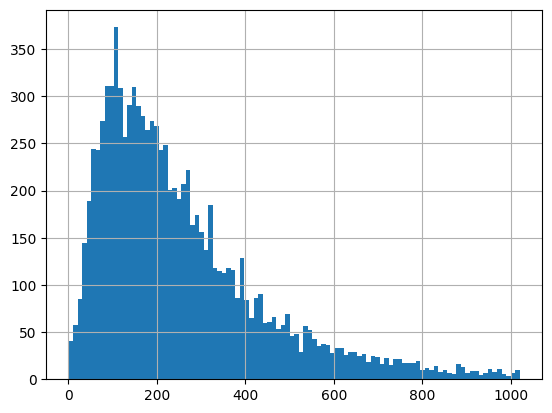

In [12]:
df.token_count.hist(bins=100);

In [13]:
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)


system_template = "You're a legal journalist. You're helping me write a concise topic title for legal questions."
human_template = "Using the following legal questions, write a concise tag line.\n\nQUESTIONS:{body}\n\nTAG LINE:"

prompt = ChatPromptTemplate(
    messages=[
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ],
    input_variables=["body"],
)
    
chain = LLMChain(
    llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo"), prompt=prompt, verbose=False
)

In [14]:
list_to_chain = df_dedup[["body"]].to_dict('records')
len(list_to_chain)

9623

In [15]:
usage = Usage()

In [16]:
from tqdm import tqdm
batch_size = 1
results = []

start_time = time.time()

for i, batch_start in tqdm(enumerate(range(0, len(list_to_chain), batch_size)), total=len(list_to_chain)//batch_size):
    batch = list_to_chain[batch_start: batch_start + batch_size]
    processed_batch = chain.run(batch)
    results.append(processed_batch)

final_time = time.time() - start_time
print(f"Total elapsed time: {final_time:.2f} seconds")

100%|██████████| 9623/9623 [3:22:50<00:00,  1.26s/it]    

Total elapsed time: 12170.79 seconds


In [17]:
usage.total_tokens()/1000*0.002

6.483348

In [18]:
# Check if 'results' length is same as the original data
assert len(results) == len(df_dedup), "Length of the result does not match with the original data"

In [19]:
results[0]

'"Legal implications of mass termination and potential for wrongful termination class-action lawsuit at Cafe Mooby"'

In [1]:
# df_dedup['llm_title'] = pd.DataFrame(results)

In [21]:
df_dedup.head(2)

,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."


In [ ]:
# df_dedup.to_parquet("legal_reddit_df_with_titles.parquet")

In [5]:
df = pd.read_parquet("legal_reddit_df_with_titles.parquet")

In [6]:
print(df.shape)
df.head(2)

(9623, 10)


,created_utc,full_link,id,body,title,text_label,flair_label,embeddings,token_count,llm_title
0,1588353888,https://www.reddit.com/r/legaladvice/comments/...,gbmcb0,The title says most of it. I just heard back f...,My former employer fired everyone when they ha...,employment,5,"[-0.009678525544039132, -0.030654356001073007,...",156,"""Legal implications of mass termination and po..."
1,1575490057,https://www.reddit.com/r/legaladvice/comments/...,e64ze3,"In Maine, my landlord (commercial property man...",Landlord is updating snow removal policies and...,housing,7,"[-0.014251169117179163, -0.0037985407615359528...",218,"""Unforeseen snow removal policy changes and po..."
